# Comparing Total Gas Masses Between Analyses - XXL-100-GC

This notebook measures gas masses for the XXL-100-GC sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

In [2]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:05<09:38,  5.90s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:13<10:58,  6.79s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [01:21<06:01,  4.41s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                    | 18/99 [01:25<05:42,  4.23s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-99 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▋                                    | 19/99 [01:29<05:37,  4.22s/it]/mnt/pact/dt23

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-25 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  34%|███████████████▍                             | 34/99 [04:14<16:57, 15.65s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-41 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  35%|███████████████▉                             | 35/99 [04:40<19:54, 18.67s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-50 has not been detected in all regi

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-104 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  47%|█████████████████████▎                       | 47/99 [06:48<07:50,  9.05s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-88 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  48%|█████████████████████▊                       | 48/99 [06:56<07:20,  8.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-87 has not been detected in all reg

Setting up Galaxy Clusters:  64%|████████████████████████████▋                | 63/99 [07:49<01:16,  2.11s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-534 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  65%|█████████████████████████████                | 64/99 [07:51<01:16,  2.19s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-517 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  66%|█████████████████████████████▌               | 65/99 [07:54<01:15,  2.22s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  80%|███████████████████████████████████▉         | 79/99 [08:36<00:48,  2.45s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-512 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  81%|████████████████████████████████████▎        | 80/99 [08:39<00:49,  2.60s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  82%|████████████████████████████████████▊        | 81/99 [08:40<00:41,  2.33s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  98%|████████████████████████████████████████████ | 97/99 [09:40<00:08,  4.02s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-510 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  99%|████████████████████████████████████████████▌| 98/99 [09:42<00:03,  3.56s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-511 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 99/99 [09:43<00:00,  5.90s/it]


In [4]:
del xxl_srcs['XLSSC-11']

## Running PSF Correction

In [5]:
rl_psf(xxl_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 96/96 [00:08<00:00, 11.40it/s]


## Reading in literature data

### Gas masses from literature

In [6]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

### Conversion Temperatures

In [7]:
xxl_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [8]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [9]:
xxl_beta_13_dp = inv_abel_fitted_model(xxl_srcs, 'beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 96/96 [00:21<00:00,  4.44it/s]
Fitting data, inverse Abel transforming, and measuring densities:   9%|▊       | 9/96 [03:04<29:25, 20.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [116.32469718 139.86932729 507.38751406]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 14/96 [04:48<28:31, 20.87s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▎    | 31/96 [10:58<23:48, 21.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 377.41105473  716.66582825 1447.34683506]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 43/96 [15:29<18:46, 21.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 174.79933125  941.20128931 1340.36198184]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/96 [21:14<13:21, 21.65s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/96 [29:22<04:58, 21.35s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/

In [10]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [11]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)


Fitting density model to XXL profiles:  33%|███████████▎                      | 32/96 [16:14<35:43, 33.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 323.18937957 2483.87301291 2495.05158513]


Fitting density model to XXL profiles:  83%|████████████████████████████▎     | 80/96 [41:10<08:19, 31.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 277.12381579 1077.80571853  945.59417338]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 96/96 [48:28<00:00, 30.29s/it]


In [12]:
xxl_beta_king_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", xxl_srcs[dp.src_name].r500)[0]
            xxl_beta_king_13_gm.append(gm)
        else:
            xxl_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_beta_king_13_gm = Quantity(xxl_beta_king_13_gm, 'Msun')

Calculating XXL gas masses:  44%|███████████████████▋                         | 42/96 [00:45<00:54,  1.01s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:467: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, inner_radius.value, outer_radius.value,
Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 96/96 [01:48<00:00,  1.13s/it]


In [13]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_beta_king_13_gm[:, 0]).sum(), t=len(xxl_beta_king_13_gm)))

92 out of 96 gas mass measurements produced a result


This section deals with two data problems, one with the literature XXL values (where an XXL gas mass is smaller than its uncertainty - messes up the plot), and another with an XGA measurement. This measurement was very low mass, and again was messing up the plot. I have made this section print the name of the cluster with this problem, but it is also removed from the gas mass array to improve the look of the figure.

In [14]:
if np.any((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]) < 0):
    xxl_lit_gms[np.argmin((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]))] = Quantity([np.NaN, np.NaN], 'Msun')

if len(xxl_beta_king_13_gm[xxl_beta_king_13_gm < Quantity(1e+8, 'Msun')]) != 0:
    which_low = np.where(xxl_beta_king_13_gm[:, 0] < Quantity(1e+8, 'Msun'))[0]
    print(xxl_srcs.names[which_low])
    xxl_beta_king_13_gm[which_low] = np.NaN

['XLSSC-90']


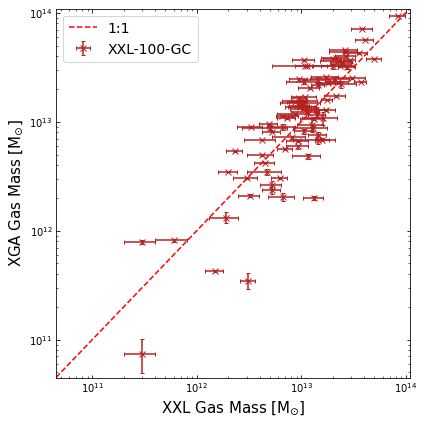

In [15]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("../../outputs/figures/xxl_beta_king_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [16]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [17]:
xxl_dblbeta_13_dp = inv_abel_fitted_model(xxl_srcs, 'double_beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/96 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-94's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   1%|        | 1/96 [00:20<32:00, 20.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [280.77729384 453.58169042 435.53072115 272.15019177 403.55188102
 434.56923628]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-96's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 2/96 [00:42<33:09, 21.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 273.99362987  804.00952107 1321.27914542  271.31217782  446.08107956
 1121.22281369]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-102's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 4/96 [01:24<32:47, 21.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 366.93633939  901.39730877 1755.91848419  562.05546499  711.96383961
 1669.62662899]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-107's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 5/96 [01:44<31:48, 20.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 557.44464281 1272.35252204 1436.57119146  310.18780148  548.37904241
 1350.81782539]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-100's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   6%|▌       | 6/96 [02:04<30:52, 20.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [804.70815559 855.80059752 862.46189811 602.72848384 920.60082243
 987.86959396]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-93's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 7/96 [02:26<31:03, 20.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [340.21183316 548.33389581 713.62756259 356.64466479 639.69637333
 611.33399429]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-108's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 8/96 [02:47<30:48, 21.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 598.16302535 2077.08485615 2161.42617479  211.89509138  354.26446656
 1843.79796861]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-95's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▊       | 9/96 [03:07<30:04, 20.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [333.71908411 770.15529712 848.60803593 401.24179067 718.76503365
 698.23397988]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-92's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  10%|▋      | 10/96 [03:28<29:43, 20.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 558.53688165 1192.3387118  1877.22645793  235.37283383  315.79006458
 1658.48109726]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▊      | 11/96 [03:49<29:18, 20.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [485.91325722 637.22388334 585.93171578 415.45315848 504.62106655
 669.27613335]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-109's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  12%|▉      | 12/96 [04:09<28:54, 20.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 730.58923572 2078.51224285 2172.61864238  238.25691362  377.69539104
 2081.04884991]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-112's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  14%|▉      | 13/96 [04:32<29:38, 21.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 710.15137291 1732.04596419 2254.22715236  344.56730375  404.91561951
 2165.8720895 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-83's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 14/96 [04:53<28:59, 21.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 596.33299018 1094.91472439 1074.54672883  484.2474007   928.92027913
  903.87906772]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  16%|█      | 15/96 [05:14<28:19, 20.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 344.73365     483.02041665 2310.9534979   493.16344729  716.22534224
  968.98256342]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-85's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  17%|█▏     | 16/96 [05:35<28:03, 21.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [267.89843341 673.25658203 884.18077717 256.49952347 558.36513177
 824.71777954]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▏     | 17/96 [05:58<28:46, 21.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 503.50276457  587.94896577 1480.01720969 1291.40227299 1077.08481039
 1079.19796217]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▎     | 18/96 [06:21<28:50, 22.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 326.10830534  582.58913275 1851.18918873 1070.71839623 1367.13438712
 1231.96761896]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▍     | 19/96 [06:43<28:20, 22.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [223.37007281 368.10280163 463.80452228 223.36137933 345.37474268
 449.66021101]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  21%|█▍     | 20/96 [07:04<27:23, 21.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 671.62638022 1466.35398073 1438.97025443  649.77434107  920.04670757
 1265.89645327]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-110's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 21/96 [07:24<26:31, 21.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [502.75897358 624.78386984 720.18003067 375.22771026 417.25962534
 672.31082271]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▌     | 22/96 [07:51<28:27, 23.08s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-72's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 23/96 [08:14<27:42, 22.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 405.36983216  491.1610386  1000.18058018  876.31807005  743.1181727
  870.88564839]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-56's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  25%|█▊     | 24/96 [08:36<27:06, 22.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 636.14621058 1176.36104391 1826.74812585  281.59638907  401.89055061
 1708.48057193]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 25/96 [09:01<27:40, 23.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [197.54682876 275.73603646 471.40132004 191.0370136  183.52015268
 146.91836192]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-23's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  27%|█▉     | 26/96 [09:21<26:08, 22.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 508.39311602  789.72586284 1114.70650505  598.11388448  714.20203452
  801.90564592]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 27/96 [09:45<26:15, 22.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 657.66533494  790.00193504 1966.30863629 1499.1710816  1746.59780753
 1991.66500407]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 28/96 [10:06<25:17, 22.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1165.40182027 1476.79356021 1825.45112685 1149.78963414 1292.1859857
 1646.3439219 ]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 29/96 [10:27<24:37, 22.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1082.59351839 2243.20703236 1308.78020102 1629.9818542  1803.14346488
 2012.75904708]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [385.95819289 892.58606022 895.59403236 471.33077719 525.17762949
 372.86153223]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 30/96 [10:52<25:01, 22.75s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-1's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▎    | 31/96 [11:14<24:33, 22.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 496.7114441   678.82334998 1673.5172994  1381.51073068 1209.35713885
  979.58144376]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1187.89632929  813.03198651 1115.96897486  415.98334672  368.90533621
  371.26505165]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-54's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 33/96 [12:09<26:11, 24.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 283.57613012  333.76939613 1123.8903729   947.83916842 1014.33254502
  607.99884787]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 34/96 [12:36<26:29, 25.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 373.13166796  821.56648374 1203.33546001  878.82939379 1058.27757104
 1408.92376834]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 837.98778385 1469.04081768 1235.84780604  988.64088512 1062.21018279
 1332.45030938]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 36/96 [13:21<24:03, 24.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 481.05139627  655.35569892 1367.27723401  776.27480766 1089.62325616
 1155.51927549]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-52's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 37/96 [13:43<23:08, 23.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 559.15609807 1048.45382799 1764.14996567  788.39570687  942.54094072
 1464.74723954]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 38/96 [14:04<22:05, 22.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1162.15566505 2265.23939406 1334.0528963  2091.95247338 2153.02221695
 2144.14761361]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-103's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  41%|██▊    | 39/96 [14:26<21:18, 22.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 384.49102491  948.53375887 1333.10055125  261.74648336  438.86561843
  911.93179456]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 40/96 [14:48<20:42, 22.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 610.01591568 1325.57081118  819.92847696  769.93943049  879.21273679
 1250.98057768]


Fitting data, inverse Abel transforming, and measuring densities:  43%|██▉    | 41/96 [15:10<20:30, 22.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 813.38459503 1487.2945456  1587.68933993 1247.09926603 1259.65742714
 1576.83142121]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-27's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 42/96 [15:33<20:11, 22.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 731.62161987  830.42776672 1194.19719874  294.69400728  442.72050577
 1120.90151478]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-90's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 43/96 [15:53<19:07, 21.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1064.39565684 1172.67716905 1426.73931909  983.18858098 1646.28947792
 1415.11986576]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-89's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  46%|███▏   | 44/96 [16:13<18:18, 21.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [353.42747599 602.17860738 913.79579025 324.5052307  504.62028391
 672.09985754]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-104's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 45/96 [16:35<18:13, 21.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 921.80537459 1627.02513219 1910.78215234  250.75771072  402.44098475
 1766.73643265]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-88's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 46/96 [16:55<17:36, 21.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 611.26583385 1540.83153845 1228.58268936  623.27266726 1577.10379357
 1447.5303988 ]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 47/96 [17:21<18:18, 22.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 212.10327464  407.74694991 1360.7976343  1369.3439268  1482.39691952
  220.97679707]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 49/96 [18:10<18:23, 23.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 231.74282434 1588.65247358  493.24396339 1424.35429829 1552.69657252
 1510.4624291 ]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 51/96 [18:58<17:47, 23.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [413.24117808 303.44810344 468.37486929 422.44942538 501.55523947
 560.46036772]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-501's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 52/96 [19:19<16:45, 22.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 416.37423196  767.2719911  1092.16503358  510.56531365  931.16175874
 1026.3307293 ]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 53/96 [19:42<16:24, 22.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [248.68661111 720.44262359 529.93074656 242.16624034 253.68173064
 350.68853706]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-525's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 54/96 [20:04<15:46, 22.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 561.78360424  715.36201472 1241.34777305  910.65476848  824.98776268
 1002.78792175]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-528's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  57%|████   | 55/96 [20:24<14:56, 21.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [555.61120419 931.58222907 786.57340289 451.38726854 435.79417748
 744.56197678]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-529's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 56/96 [20:44<14:17, 21.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 707.74760841  803.9812656  1632.46873116  226.65810478  264.99369403
 1580.97496648]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-526's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|████▏  | 57/96 [21:06<13:53, 21.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1025.62742656 1435.1122518  1548.37440518  283.10360884  320.34002984
 1484.54824468]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 308.5037267   840.95745415 1252.81717733  372.98154999  406.13334993
  372.31467367]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/96 [21:52<13:37, 22.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 345.17762167 1013.53989965 1478.95453342  402.91904477 1000.21983158
 1402.10358716]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|████▍  | 60/96 [22:12<12:51, 21.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [398.383907   831.93421348 618.87802578 452.23778944 649.88572984
 554.81918584]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-534's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|████▍  | 61/96 [22:32<12:14, 20.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 326.79548242  969.32368895 1251.3625745   317.30486292  532.13663788
 1081.59628303]


Fitting data, inverse Abel transforming, and measuring densities:  65%|████▌  | 62/96 [22:52<11:41, 20.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [322.46270544 409.21638838 572.14879812 373.44001026 419.73395052
 432.08651238]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-523's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  66%|████▌  | 63/96 [23:12<11:13, 20.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [571.3698802  909.20946269 906.14111264 576.06535671 967.30365582
 813.94800912]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-503's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 64/96 [23:32<10:56, 20.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 499.74627792  782.25706522 1108.58864542  598.49837677 1045.39544549
  943.1241892 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-545's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  68%|████▋  | 65/96 [23:52<10:29, 20.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [349.75280837 746.97632877 688.58645127 346.34347977 680.34847416
 723.18934542]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 66/96 [24:16<10:39, 21.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 194.79445638  386.83731067 1585.09590026 1112.79060625 1042.22616273
  293.11174436]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 68/96 [25:03<10:21, 22.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [356.98615745 849.36474752 613.45682236 372.62342249 671.86349067
 512.06201027]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-535's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 69/96 [25:24<09:53, 21.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1380.37430584 1353.720218   1513.10386098 1604.60004334 1298.43354415
 1553.77014709]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-536's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  73%|█████  | 70/96 [25:45<09:20, 21.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [443.07438042 883.72703791 946.24711084 537.56937194 544.99152467
 399.37425733]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 71/96 [26:06<08:56, 21.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 490.63747045 1479.56261508 1512.67145034  365.69071486  537.35313983
 1442.91834597]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [231.63482121 379.39981316 294.30183828 241.2783227  423.75874449
 260.3892514 ]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 73/96 [26:51<08:25, 21.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 584.84308403  468.58321705 1621.58058004 1052.39406052 1256.97369605
 1278.74397548]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [208.94408664 478.75314793 444.79912744 385.95727707 462.51769238
 409.28379179]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▍ | 74/96 [27:21<08:53, 24.26s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-506's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 75/96 [27:41<08:04, 23.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 485.84406025 1117.01691912 1234.93614737  274.95373528  327.21153996
 1112.71574747]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-546's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 76/96 [28:01<07:25, 22.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [466.55933072 833.41566837 793.92315703 291.24042444 431.58413733
 780.14997383]


Fitting data, inverse Abel transforming, and measuring densities:  80%|█████▌ | 77/96 [28:22<06:55, 21.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 325.8820049  1057.16640201  643.63770617  288.11529538  524.11356407
  542.71713654]


Fitting data, inverse Abel transforming, and measuring densities:  81%|█████▋ | 78/96 [28:46<06:45, 22.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [229.86979473 286.3438577  475.92170878 233.58395682 233.66414319
 163.61878859]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-532's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▊ | 79/96 [29:07<06:11, 21.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [336.45592304 564.77990791 613.95178799 432.88422655 609.7460954
 619.16718927]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-519's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  83%|█████▊ | 80/96 [29:29<05:50, 21.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [259.10634516 388.32023815 813.75221242 623.81912481 514.9658836
 208.18238009]


Fitting data, inverse Abel transforming, and measuring densities:  84%|█████▉ | 81/96 [29:50<05:23, 21.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [320.91822639 919.80110434 853.03657944 383.30199216 853.18546076
 435.25142939]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/96 [30:15<05:16, 22.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [428.73597734 362.75688028 348.66059045 492.42077285 465.3273754
 413.22195638]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-507's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  86%|██████ | 83/96 [30:34<04:39, 21.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [471.63964013 877.38953762 809.47601604 526.07299959 747.09936194
 559.77804297]


Fitting data, inverse Abel transforming, and measuring densities:  88%|██████▏| 84/96 [30:56<04:20, 21.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [266.12988513 358.19262717 444.94962484 346.58324701 327.45319982
 371.89474495]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-516's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  89%|██████▏| 85/96 [31:15<03:51, 21.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 893.273773   1566.44193447 1956.60274128  946.1322048  1373.43775378
 1979.65037362]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-537's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 86/96 [31:36<03:29, 20.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [373.17401077 621.97043041 889.07523787 274.17777032 552.7294217
 873.96057146]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-548's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|██████▎| 87/96 [31:56<03:06, 20.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 270.25728184  400.40044301 1429.17357195  216.82841887  372.07482666
 1083.44510084]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-538's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  92%|██████▍| 88/96 [32:17<02:45, 20.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 336.72539483  852.00269112 1574.32991581  363.11665651  878.65582671
 1297.8215904 ]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▍| 89/96 [32:37<02:23, 20.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 635.749376   1654.5416165  1111.47417744  561.12415263  614.0165866
  820.72238863]


Fitting data, inverse Abel transforming, and measuring densities:  94%|██████▌| 90/96 [33:01<02:08, 21.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [547.61477661 496.3443763  564.14354572 681.80932292 663.18445563
 779.42205845]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-508's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 91/96 [33:22<01:47, 21.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 642.09230209  336.58681958 1889.22670036  279.39600734  274.5451918
 1801.02979027]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-540's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 92/96 [33:43<01:24, 21.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 350.71792124 1139.18106115 1405.47902311  393.3298759   912.79307643
 1346.40806445]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 93/96 [34:04<01:03, 21.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [251.29933744 874.34197195 828.24649221 299.61428747 786.29956462
 809.1131917 ]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 94/96 [34:24<00:41, 20.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 489.66461614 1745.9313267  1391.97493315  679.21398381 1598.3758709
 1549.59447944]


Fitting data, inverse Abel transforming, and measuring densities:  99%|██████▉| 95/96 [34:44<00:20, 20.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [271.66064897 553.73902471 771.16603048 337.87417039 621.33763802
 766.85193004]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 96/96 [35:07<00:00, 21.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 278.38701618 1159.00849062 1022.51451937  333.30322724  409.17570895
  544.69640843]


In [18]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [19]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to XXL profiles:  11%|███▉                              | 11/96 [01:12<08:49,  6.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [623.88671144 690.9144426  668.00040925 510.75913892 364.1325721
 768.73327252]


Fitting density model to XXL profiles:  18%|██████                            | 17/96 [01:54<08:38,  6.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [159.51524926 208.78553724 762.75315391 140.06787677 124.33195915
 274.70117371]


Fitting density model to XXL profiles:  19%|██████▍                           | 18/96 [02:32<12:42,  9.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [192.26946158 219.52450538 873.98361398 201.10539028 153.32324523
 249.07682874]


Fitting density model to XXL profiles:  20%|██████▋                           | 19/96 [03:09<16:48, 13.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 515.40577904 1534.40909826  464.3645293  1211.07725347  475.55276127
  657.10266187]


Fitting density model to XXL profiles:  23%|███████▊                          | 22/96 [04:02<18:09, 14.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 826.33210839 1255.38298251 1053.48346309 1204.09772895  958.93816936
 1245.84970884]


Fitting density model to XXL profiles:  26%|████████▊                         | 25/96 [04:41<16:41, 14.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 951.45013466 2345.07425593 1121.54917481 1778.886102    756.59261987
 1671.89611171]


Fitting density model to XXL profiles:  28%|█████████▌                        | 27/96 [05:20<17:46, 15.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [188.96471468 216.85680616 760.47700066 389.68007118 359.07444589
 771.12996338]


Fitting density model to XXL profiles:  29%|█████████▉                        | 28/96 [05:57<21:01, 18.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1099.19929296 1304.94581202 1416.99934599  720.29392307  362.13893567
 1430.00962068]


Fitting density model to XXL profiles:  30%|██████████▎                       | 29/96 [06:31<23:45, 21.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1990.25834532 2152.5430827  1895.16531516 1441.07942522  823.09493842
 2212.51284939]


Fitting density model to XXL profiles:  31%|██████████▋                       | 30/96 [07:13<27:54, 25.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 623.39546539 1368.78720984  712.14396425 1252.88384175  467.9973661
  999.27559529]


Fitting density model to XXL profiles:  35%|████████████                      | 34/96 [08:37<25:07, 24.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 963.16469171 2345.00763333 1545.53766622  731.88723891  623.52496986
 2476.2049711 ]


Fitting density model to XXL profiles:  36%|████████████▍                     | 35/96 [09:19<28:21, 27.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 914.4618751  1128.12843892  773.3125927  1320.99607105  539.81407458
  967.82967396]


Fitting density model to XXL profiles:  40%|█████████████▍                    | 38/96 [10:37<25:08, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1278.89511256 1575.3715483  1407.82736167  958.9549039   576.39205386
 1591.24490431]


Fitting density model to XXL profiles:  42%|██████████████▏                   | 40/96 [11:11<21:12, 22.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3108.02133161 3521.560467   3189.19303147 2573.13872252 1570.88794302
 3535.02984596]


Fitting density model to XXL profiles:  43%|██████████████▌                   | 41/96 [11:49<23:44, 25.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2377.81088551 2626.69821891 3187.77495381 1902.53034023  785.42563065
 2847.76273164]


Fitting density model to XXL profiles:  49%|████████████████▋                 | 47/96 [12:31<11:16, 13.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [101.56301322 159.26265148 911.04525353 102.25433028 127.13533162
 278.11970639]


Fitting density model to XXL profiles:  50%|█████████████████                 | 48/96 [13:21<14:51, 18.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1332.71070354 1897.68494643 1440.52889032 1859.06029609 1089.63300449
 1761.88892882]


Fitting density model to XXL profiles:  52%|█████████████████▋                | 50/96 [14:37<18:51, 24.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3414.95066518 3641.04418027 3669.18967655 2464.98526727 2808.47686533
 3637.97169092]


Fitting density model to XXL profiles:  53%|██████████████████                | 51/96 [15:15<20:39, 27.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1420.50894676 2675.57867999 1697.73346358  938.08330436  740.82225295
 2456.92488537]


Fitting density model to XXL profiles:  55%|██████████████████▊               | 53/96 [15:53<17:27, 24.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [398.23741225 733.9375807  523.75876404 601.05675238 465.16094418
 710.30068968]


Fitting density model to XXL profiles:  61%|████████████████████▉             | 59/96 [17:14<11:22, 18.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 435.54024142  682.94186797 1026.01043719  298.77301831  228.68670567
  768.45008684]


Fitting density model to XXL profiles:  65%|█████████████████████▉            | 62/96 [17:48<08:56, 15.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [373.41725526 611.99319131 361.98231826 700.44653897 295.01810338
 409.18757585]


Fitting density model to XXL profiles:  69%|███████████████████████▍          | 66/96 [18:26<06:34, 13.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 234.69420351  577.11976749 1204.92880649  242.28900657  228.01527343
  606.97692338]


Fitting density model to XXL profiles:  70%|███████████████████████▋          | 67/96 [19:08<08:07, 16.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [415.39880635 788.47065051 389.98729739 764.11024363 407.18055651
 740.3043678 ]


Fitting density model to XXL profiles:  71%|████████████████████████          | 68/96 [19:44<09:15, 19.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 812.86193957 1711.26561979 1039.37316925 1442.71089357  563.96621304
 1237.46708711]


Fitting density model to XXL profiles:  74%|█████████████████████████▏        | 71/96 [20:20<06:56, 16.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 917.3225786  1401.99926869  492.15226834 1411.36379517 1336.97980865
  702.1479338 ]


Fitting density model to XXL profiles:  76%|█████████████████████████▊        | 73/96 [21:39<09:07, 23.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [405.63001738 529.17031043 967.90927305 353.18741764 190.18926736
 726.30489789]


Fitting density model to XXL profiles:  77%|██████████████████████████▏       | 74/96 [22:30<10:47, 29.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [695.23241864 400.72837367 343.35241265 537.9855638  236.96121072
 374.66126542]


Fitting density model to XXL profiles:  80%|███████████████████████████▎      | 77/96 [23:06<06:43, 21.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [560.89818728 882.48071744 671.04775409 975.93851438 448.12844664
 717.93040453]


Fitting density model to XXL profiles:  81%|███████████████████████████▋      | 78/96 [23:45<07:19, 24.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1404.36633318 1747.12693552 1023.03631371 1903.0248909   752.34299222
 1374.35777366]


Fitting density model to XXL profiles:  84%|████████████████████████████▋     | 81/96 [24:21<04:45, 19.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 651.22584098 1359.90024657  482.76844516 1032.16415321  486.20339998
  626.45479089]


Fitting density model to XXL profiles:  85%|█████████████████████████████     | 82/96 [25:03<05:21, 22.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2130.26342811 3023.11043515 1625.12398546 1138.80345054  766.23325522
 3123.06400675]


Fitting density model to XXL profiles:  88%|█████████████████████████████▊    | 84/96 [25:37<04:11, 20.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 837.84562695 1196.61577934  646.02613626 1282.6284346   683.48595093
  866.58188893]


Fitting density model to XXL profiles:  93%|███████████████████████████████▌  | 89/96 [26:11<01:33, 13.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 836.54898787 1294.58683047  995.17423626  899.62018574  824.08780489
 1079.88872362]


Fitting density model to XXL profiles:  94%|███████████████████████████████▉  | 90/96 [26:52<01:42, 17.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2568.78179851 2794.68864293 3472.1595203  1925.48416677  862.79027748
 2790.35259991]


Fitting density model to XXL profiles:  97%|████████████████████████████████▉ | 93/96 [27:28<00:45, 15.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [413.56550351 872.66466721 333.49639747 515.59387015 254.84578488
 335.99090591]


Fitting density model to XXL profiles:  98%|█████████████████████████████████▎| 94/96 [28:01<00:35, 17.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 948.9342224  1791.84747777 1194.36886822 1004.79356264  579.38038019
 1702.19182502]


Fitting density model to XXL profiles:  99%|█████████████████████████████████▋| 95/96 [28:36<00:20, 20.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 286.79955435  351.59212657 2431.53760615  254.37208222  183.27341157
  642.52481266]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 96/96 [29:14<00:00, 18.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 599.16717021 1287.32315851  705.10605677  768.28132323  456.50052937
 1003.15235426]


In [20]:
xxl_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_13_gm.append(gm)
        else:
            xxl_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_dblbeta_svikh_13_gm = Quantity(xxl_dblbeta_svikh_13_gm, 'Msun')

Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 96/96 [06:09<00:00,  3.85s/it]


In [21]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_dblbeta_svikh_13_gm[:, 0]).sum(), t=len(xxl_dblbeta_svikh_13_gm)))

45 out of 96 gas mass measurements produced a result


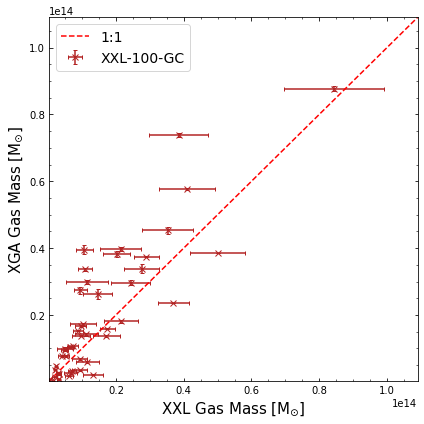

In [22]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
# plt.savefig("non_paper_figures/xxl_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')